In [159]:
%pip install torch torchvision --quiet
%pip install scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [160]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
np.random.seed(123)

In [113]:
#Data split 
# Download training data from open datasets.

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64

dataset = training_data + test_data

In [114]:
count = {}
for x, y in dataset:
    count[y] = count.get(y, 0) + 1

count = dict(sorted(count.items(), key=lambda x: x[1]))
print(count)

{5: 6313, 4: 6824, 8: 6825, 6: 6876, 0: 6903, 9: 6958, 2: 6990, 3: 7141, 7: 7293, 1: 7877}


In [115]:
number_set = {}
number_dataloader = {}
for i in tqdm(count.keys()):
    print(f"At {i}")
    number_set[i] = [x for x, y in dataset if y == i]
    number_dataloader[i] = DataLoader(number_set[i], batch_size=batch_size)

  0%|          | 0/10 [00:00<?, ?it/s]

At 5


 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

At 4


 20%|██        | 2/10 [00:03<00:12,  1.53s/it]

At 8


 30%|███       | 3/10 [00:04<00:10,  1.54s/it]

At 6


 40%|████      | 4/10 [00:06<00:09,  1.54s/it]

At 0


 50%|█████     | 5/10 [00:07<00:07,  1.54s/it]

At 9


 60%|██████    | 6/10 [00:09<00:06,  1.54s/it]

At 2


 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

At 3


 80%|████████  | 8/10 [00:12<00:03,  1.54s/it]

At 7


 90%|█████████ | 9/10 [00:14<00:01,  1.67s/it]

At 1


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


In [116]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )


    def forward(self, x):
        flat_x = self.flatten(x)
        latente = self.encoder(flat_x)
        pred = self.decoder(latente)

        return pred
    

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), #16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconst = self.decoder(encoded)

        return reconst

In [121]:
loss_fn = nn.MSELoss()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu" 
print(f"using {device} device")
 
AE = AutoEncoder().to(device=device)
learning_rate = 3e-4
optm = torch.optim.Adam(AE.parameters(), lr=learning_rate)

CNN_AE = CNNAutoEncoder().to(device=device)
cnn_learning_rate = 3e-4
cnn_optm = torch.optim.Adam(CNN_AE.parameters(), lr=cnn_learning_rate)

using mps device


In [234]:
# Define the train function
def train(data, model, loss_fn, opt, cnn=False, num_epochs=100, patience=7, device=device, eps=1e-5):
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X in tqdm(data):
            X = X.to(device=device)
            if not cnn: X = torch.reshape(X, (X.shape[0], 28*28))
            pred = model(X)
            loss = loss_fn(pred, X)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.5f}")

        # Check for early stopping
        if avg_loss < (best_loss + eps):
            best_loss = avg_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print("No improvement in loss")
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

In [240]:

def identify_outliers(data, model, loss_fn, cnn=False):
    model.eval()
    all_model_losses = []

    with torch.no_grad():
        for X in data:
            X = X.to(device=device)
            if not cnn: 
                X = torch.reshape(X, (X.shape[0], 28*28))
            pred = model(X)
            
            if cnn:
                losses = loss_fn(pred, X).mean(dim=1).mean(dim=1).mean(dim=1)
            else:
                losses = loss_fn(pred, X).mean(dim=1)
        
            for i in range(len(losses)):
                loss_item = losses[i].item()
                all_model_losses.append((X[i].cpu().numpy(), loss_item))
    
    all_loss = {idx: (loss, image) for idx, (image, loss) in enumerate(all_model_losses)}
    all_loss = {k: v for k, v in sorted(all_loss.items(), key=lambda item: item[1][0], reverse=True)}

    return all_loss

def plot_outliers(outliers, label, arch='AE', num_images=64):
    
    grid_size = int(np.sqrt(num_images))
    # Create a figure with 4x4 subplots
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))  
    fig.suptitle(f'Outliers for Label: {label}, Arch: {arch}', fontsize=64)
    
    # Iterate over the top num_images outliers
    for i, (_, (error, image)) in enumerate(list(outliers.items())[:num_images]):
        row = i // grid_size
        col = i % grid_size
        axs[row, col].imshow(image.reshape(28, 28), cmap='gray')
        axs[row, col].set_title(f'Error: {error:.4f}', fontsize=24)  
        axs[row, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.99])  
    plt.show()

In [257]:
LABEL = 4
training_data = number_dataloader[LABEL]

In [258]:
AE = AutoEncoder().to(device=device)
learning_rate = 3e-4
optm = torch.optim.Adam(AE.parameters(), lr=learning_rate)
train(training_data, AE, loss_fn, optm, cnn=False, num_epochs=200, patience=7)
singleton_loss_fn = torch.nn.MSELoss(reduction='none')

100%|██████████| 107/107 [00:01<00:00, 80.42it/s] 


Epoch 1/200, Loss: 0.11082


100%|██████████| 107/107 [00:00<00:00, 147.13it/s]


Epoch 2/200, Loss: 0.05335


100%|██████████| 107/107 [00:00<00:00, 172.84it/s]


Epoch 3/200, Loss: 0.05229


100%|██████████| 107/107 [00:00<00:00, 177.24it/s]


Epoch 4/200, Loss: 0.05143


100%|██████████| 107/107 [00:00<00:00, 169.06it/s]


Epoch 5/200, Loss: 0.04838


100%|██████████| 107/107 [00:00<00:00, 170.84it/s]


Epoch 6/200, Loss: 0.04314


100%|██████████| 107/107 [00:00<00:00, 171.92it/s]


Epoch 7/200, Loss: 0.03959


100%|██████████| 107/107 [00:00<00:00, 175.22it/s]


Epoch 8/200, Loss: 0.03541


100%|██████████| 107/107 [00:00<00:00, 175.74it/s]


Epoch 9/200, Loss: 0.03333


100%|██████████| 107/107 [00:00<00:00, 172.67it/s]


Epoch 10/200, Loss: 0.03180


100%|██████████| 107/107 [00:00<00:00, 170.90it/s]


Epoch 11/200, Loss: 0.03058


100%|██████████| 107/107 [00:00<00:00, 168.04it/s]


Epoch 12/200, Loss: 0.02959


100%|██████████| 107/107 [00:00<00:00, 169.49it/s]


Epoch 13/200, Loss: 0.02868


100%|██████████| 107/107 [00:00<00:00, 171.74it/s]


Epoch 14/200, Loss: 0.02773


100%|██████████| 107/107 [00:00<00:00, 170.71it/s]


Epoch 15/200, Loss: 0.02644


100%|██████████| 107/107 [00:00<00:00, 168.87it/s]


Epoch 16/200, Loss: 0.02519


100%|██████████| 107/107 [00:00<00:00, 167.34it/s]


Epoch 17/200, Loss: 0.02446


100%|██████████| 107/107 [00:00<00:00, 169.10it/s]


Epoch 18/200, Loss: 0.02390


100%|██████████| 107/107 [00:00<00:00, 170.05it/s]


Epoch 19/200, Loss: 0.02320


100%|██████████| 107/107 [00:00<00:00, 160.60it/s]


Epoch 20/200, Loss: 0.02217


100%|██████████| 107/107 [00:00<00:00, 171.19it/s]


Epoch 21/200, Loss: 0.02116


100%|██████████| 107/107 [00:00<00:00, 172.08it/s]


Epoch 22/200, Loss: 0.02040


100%|██████████| 107/107 [00:00<00:00, 175.29it/s]


Epoch 23/200, Loss: 0.01986


100%|██████████| 107/107 [00:00<00:00, 177.33it/s]


Epoch 24/200, Loss: 0.01946


100%|██████████| 107/107 [00:00<00:00, 175.35it/s]


Epoch 25/200, Loss: 0.01912


100%|██████████| 107/107 [00:00<00:00, 178.06it/s]


Epoch 26/200, Loss: 0.01882


100%|██████████| 107/107 [00:00<00:00, 176.83it/s]


Epoch 27/200, Loss: 0.01853


100%|██████████| 107/107 [00:00<00:00, 176.45it/s]


Epoch 28/200, Loss: 0.01826


100%|██████████| 107/107 [00:00<00:00, 176.25it/s]


Epoch 29/200, Loss: 0.01800


100%|██████████| 107/107 [00:00<00:00, 177.36it/s]


Epoch 30/200, Loss: 0.01774


100%|██████████| 107/107 [00:00<00:00, 171.22it/s]


Epoch 31/200, Loss: 0.01744


100%|██████████| 107/107 [00:00<00:00, 174.47it/s]


Epoch 32/200, Loss: 0.01708


100%|██████████| 107/107 [00:00<00:00, 159.01it/s]


Epoch 33/200, Loss: 0.01669


100%|██████████| 107/107 [00:00<00:00, 159.41it/s]


Epoch 34/200, Loss: 0.01635


100%|██████████| 107/107 [00:00<00:00, 163.17it/s]


Epoch 35/200, Loss: 0.01604


100%|██████████| 107/107 [00:00<00:00, 162.78it/s]


Epoch 36/200, Loss: 0.01579


100%|██████████| 107/107 [00:00<00:00, 155.14it/s]


Epoch 37/200, Loss: 0.01558


100%|██████████| 107/107 [00:00<00:00, 170.75it/s]


Epoch 38/200, Loss: 0.01539


100%|██████████| 107/107 [00:00<00:00, 168.62it/s]


Epoch 39/200, Loss: 0.01522


100%|██████████| 107/107 [00:00<00:00, 165.04it/s]


Epoch 40/200, Loss: 0.01506


100%|██████████| 107/107 [00:00<00:00, 169.62it/s]


Epoch 41/200, Loss: 0.01491


100%|██████████| 107/107 [00:00<00:00, 155.19it/s]


Epoch 42/200, Loss: 0.01476


100%|██████████| 107/107 [00:00<00:00, 161.46it/s]


Epoch 43/200, Loss: 0.01462


100%|██████████| 107/107 [00:00<00:00, 170.87it/s]


Epoch 44/200, Loss: 0.01449


100%|██████████| 107/107 [00:00<00:00, 174.36it/s]


Epoch 45/200, Loss: 0.01430


100%|██████████| 107/107 [00:00<00:00, 177.21it/s]


Epoch 46/200, Loss: 0.01413


100%|██████████| 107/107 [00:00<00:00, 175.78it/s]


Epoch 47/200, Loss: 0.01396


100%|██████████| 107/107 [00:00<00:00, 177.12it/s]


Epoch 48/200, Loss: 0.01381


100%|██████████| 107/107 [00:00<00:00, 176.93it/s]


Epoch 49/200, Loss: 0.01367


100%|██████████| 107/107 [00:00<00:00, 177.04it/s]


Epoch 50/200, Loss: 0.01354


100%|██████████| 107/107 [00:00<00:00, 164.67it/s]


Epoch 51/200, Loss: 0.01342


100%|██████████| 107/107 [00:00<00:00, 176.85it/s]


Epoch 52/200, Loss: 0.01332


100%|██████████| 107/107 [00:00<00:00, 174.63it/s]


Epoch 53/200, Loss: 0.01323


100%|██████████| 107/107 [00:00<00:00, 157.69it/s]


Epoch 54/200, Loss: 0.01314


100%|██████████| 107/107 [00:00<00:00, 165.79it/s]


Epoch 55/200, Loss: 0.01305


100%|██████████| 107/107 [00:00<00:00, 148.94it/s]


Epoch 56/200, Loss: 0.01298


100%|██████████| 107/107 [00:00<00:00, 161.80it/s]


Epoch 57/200, Loss: 0.01291


100%|██████████| 107/107 [00:00<00:00, 159.13it/s]


Epoch 58/200, Loss: 0.01284


100%|██████████| 107/107 [00:00<00:00, 152.56it/s]


Epoch 59/200, Loss: 0.01279


100%|██████████| 107/107 [00:00<00:00, 155.32it/s]


Epoch 60/200, Loss: 0.01274


100%|██████████| 107/107 [00:00<00:00, 162.40it/s]


Epoch 61/200, Loss: 0.01268


100%|██████████| 107/107 [00:00<00:00, 160.31it/s]


Epoch 62/200, Loss: 0.01259


100%|██████████| 107/107 [00:00<00:00, 159.43it/s]


Epoch 63/200, Loss: 0.01251


100%|██████████| 107/107 [00:00<00:00, 162.17it/s]


Epoch 64/200, Loss: 0.01244


100%|██████████| 107/107 [00:00<00:00, 164.34it/s]


Epoch 65/200, Loss: 0.01239


100%|██████████| 107/107 [00:00<00:00, 164.46it/s]


Epoch 66/200, Loss: 0.01234


100%|██████████| 107/107 [00:00<00:00, 164.93it/s]


Epoch 67/200, Loss: 0.01231


100%|██████████| 107/107 [00:00<00:00, 165.97it/s]


Epoch 68/200, Loss: 0.01228


100%|██████████| 107/107 [00:00<00:00, 163.73it/s]


Epoch 69/200, Loss: 0.01222


100%|██████████| 107/107 [00:00<00:00, 163.81it/s]


Epoch 70/200, Loss: 0.01213


100%|██████████| 107/107 [00:00<00:00, 157.89it/s]


Epoch 71/200, Loss: 0.01205


100%|██████████| 107/107 [00:00<00:00, 163.29it/s]


Epoch 72/200, Loss: 0.01198


100%|██████████| 107/107 [00:00<00:00, 164.25it/s]


Epoch 73/200, Loss: 0.01192


100%|██████████| 107/107 [00:00<00:00, 161.73it/s]


Epoch 74/200, Loss: 0.01186


100%|██████████| 107/107 [00:00<00:00, 162.56it/s]


Epoch 75/200, Loss: 0.01181


100%|██████████| 107/107 [00:00<00:00, 164.85it/s]


Epoch 76/200, Loss: 0.01177


100%|██████████| 107/107 [00:00<00:00, 165.31it/s]


Epoch 77/200, Loss: 0.01174


100%|██████████| 107/107 [00:00<00:00, 166.21it/s]


Epoch 78/200, Loss: 0.01174


100%|██████████| 107/107 [00:00<00:00, 166.95it/s]


Epoch 79/200, Loss: 0.01182
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 158.09it/s]


Epoch 80/200, Loss: 0.01170


100%|██████████| 107/107 [00:00<00:00, 166.64it/s]


Epoch 81/200, Loss: 0.01164


100%|██████████| 107/107 [00:00<00:00, 164.14it/s]


Epoch 82/200, Loss: 0.01159


100%|██████████| 107/107 [00:00<00:00, 168.99it/s]


Epoch 83/200, Loss: 0.01156


100%|██████████| 107/107 [00:00<00:00, 168.26it/s]


Epoch 84/200, Loss: 0.01158
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 168.36it/s]


Epoch 85/200, Loss: 0.01157


100%|██████████| 107/107 [00:00<00:00, 173.14it/s]


Epoch 86/200, Loss: 0.01148


100%|██████████| 107/107 [00:00<00:00, 175.59it/s]


Epoch 87/200, Loss: 0.01139


100%|██████████| 107/107 [00:00<00:00, 172.43it/s]


Epoch 88/200, Loss: 0.01131


100%|██████████| 107/107 [00:00<00:00, 157.75it/s]


Epoch 89/200, Loss: 0.01123


100%|██████████| 107/107 [00:00<00:00, 171.69it/s]


Epoch 90/200, Loss: 0.01116


100%|██████████| 107/107 [00:00<00:00, 170.26it/s]


Epoch 91/200, Loss: 0.01109


100%|██████████| 107/107 [00:00<00:00, 174.88it/s]


Epoch 92/200, Loss: 0.01102


100%|██████████| 107/107 [00:00<00:00, 171.20it/s]


Epoch 93/200, Loss: 0.01096


100%|██████████| 107/107 [00:00<00:00, 171.44it/s]


Epoch 94/200, Loss: 0.01089


100%|██████████| 107/107 [00:00<00:00, 171.23it/s]


Epoch 95/200, Loss: 0.01083


100%|██████████| 107/107 [00:00<00:00, 169.28it/s]


Epoch 96/200, Loss: 0.01077


100%|██████████| 107/107 [00:00<00:00, 168.06it/s]


Epoch 97/200, Loss: 0.01072


100%|██████████| 107/107 [00:00<00:00, 158.85it/s]


Epoch 98/200, Loss: 0.01067


100%|██████████| 107/107 [00:00<00:00, 170.07it/s]


Epoch 99/200, Loss: 0.01062


100%|██████████| 107/107 [00:00<00:00, 168.90it/s]


Epoch 100/200, Loss: 0.01057


100%|██████████| 107/107 [00:00<00:00, 168.54it/s]


Epoch 101/200, Loss: 0.01053


100%|██████████| 107/107 [00:00<00:00, 168.93it/s]


Epoch 102/200, Loss: 0.01048


100%|██████████| 107/107 [00:00<00:00, 167.52it/s]


Epoch 103/200, Loss: 0.01044


100%|██████████| 107/107 [00:00<00:00, 166.08it/s]


Epoch 104/200, Loss: 0.01039


100%|██████████| 107/107 [00:00<00:00, 169.29it/s]


Epoch 105/200, Loss: 0.01035


100%|██████████| 107/107 [00:00<00:00, 169.18it/s]


Epoch 106/200, Loss: 0.01031


100%|██████████| 107/107 [00:00<00:00, 172.79it/s]


Epoch 107/200, Loss: 0.01027


100%|██████████| 107/107 [00:00<00:00, 162.13it/s]


Epoch 108/200, Loss: 0.01023


100%|██████████| 107/107 [00:00<00:00, 171.86it/s]


Epoch 109/200, Loss: 0.01019


100%|██████████| 107/107 [00:00<00:00, 173.78it/s]


Epoch 110/200, Loss: 0.01015


100%|██████████| 107/107 [00:00<00:00, 173.69it/s]


Epoch 111/200, Loss: 0.01011


100%|██████████| 107/107 [00:00<00:00, 174.62it/s]


Epoch 112/200, Loss: 0.01008


100%|██████████| 107/107 [00:00<00:00, 174.17it/s]


Epoch 113/200, Loss: 0.01004


100%|██████████| 107/107 [00:00<00:00, 175.04it/s]


Epoch 114/200, Loss: 0.01000


100%|██████████| 107/107 [00:00<00:00, 170.52it/s]


Epoch 115/200, Loss: 0.00996


100%|██████████| 107/107 [00:00<00:00, 171.02it/s]


Epoch 116/200, Loss: 0.00993


100%|██████████| 107/107 [00:00<00:00, 158.65it/s]


Epoch 117/200, Loss: 0.00989


100%|██████████| 107/107 [00:00<00:00, 168.18it/s]


Epoch 118/200, Loss: 0.00986


100%|██████████| 107/107 [00:00<00:00, 167.40it/s]


Epoch 119/200, Loss: 0.00983


100%|██████████| 107/107 [00:00<00:00, 168.11it/s]


Epoch 120/200, Loss: 0.00980


100%|██████████| 107/107 [00:00<00:00, 166.68it/s]


Epoch 121/200, Loss: 0.00978


100%|██████████| 107/107 [00:00<00:00, 169.13it/s]


Epoch 122/200, Loss: 0.00978


100%|██████████| 107/107 [00:00<00:00, 167.75it/s]


Epoch 123/200, Loss: 0.00983
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 167.65it/s]


Epoch 124/200, Loss: 0.00982
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 170.08it/s]


Epoch 125/200, Loss: 0.00980
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 156.87it/s]


Epoch 126/200, Loss: 0.00986
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 168.47it/s]


Epoch 127/200, Loss: 0.00980
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 173.71it/s]


Epoch 128/200, Loss: 0.00967


100%|██████████| 107/107 [00:00<00:00, 175.41it/s]


Epoch 129/200, Loss: 0.00959


100%|██████████| 107/107 [00:00<00:00, 173.25it/s]


Epoch 130/200, Loss: 0.00956


100%|██████████| 107/107 [00:00<00:00, 171.92it/s]


Epoch 131/200, Loss: 0.00955


100%|██████████| 107/107 [00:00<00:00, 175.96it/s]


Epoch 132/200, Loss: 0.00959
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 174.10it/s]


Epoch 133/200, Loss: 0.00963
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 173.23it/s]


Epoch 134/200, Loss: 0.00957
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 159.98it/s]


Epoch 135/200, Loss: 0.00945


100%|██████████| 107/107 [00:00<00:00, 174.60it/s]


Epoch 136/200, Loss: 0.00935


100%|██████████| 107/107 [00:00<00:00, 173.65it/s]


Epoch 137/200, Loss: 0.00925


100%|██████████| 107/107 [00:00<00:00, 175.00it/s]


Epoch 138/200, Loss: 0.00916


100%|██████████| 107/107 [00:00<00:00, 169.73it/s]


Epoch 139/200, Loss: 0.00908


100%|██████████| 107/107 [00:00<00:00, 167.68it/s]


Epoch 140/200, Loss: 0.00901


100%|██████████| 107/107 [00:00<00:00, 168.59it/s]


Epoch 141/200, Loss: 0.00894


100%|██████████| 107/107 [00:00<00:00, 167.15it/s]


Epoch 142/200, Loss: 0.00888


100%|██████████| 107/107 [00:00<00:00, 165.54it/s]


Epoch 143/200, Loss: 0.00883


100%|██████████| 107/107 [00:00<00:00, 157.88it/s]


Epoch 144/200, Loss: 0.00878


100%|██████████| 107/107 [00:00<00:00, 168.13it/s]


Epoch 145/200, Loss: 0.00873


100%|██████████| 107/107 [00:00<00:00, 167.62it/s]


Epoch 146/200, Loss: 0.00868


100%|██████████| 107/107 [00:00<00:00, 171.19it/s]


Epoch 147/200, Loss: 0.00863


100%|██████████| 107/107 [00:00<00:00, 169.46it/s]


Epoch 148/200, Loss: 0.00859


100%|██████████| 107/107 [00:00<00:00, 166.01it/s]


Epoch 149/200, Loss: 0.00855


100%|██████████| 107/107 [00:00<00:00, 175.06it/s]


Epoch 150/200, Loss: 0.00851


100%|██████████| 107/107 [00:00<00:00, 172.07it/s]


Epoch 151/200, Loss: 0.00847


100%|██████████| 107/107 [00:00<00:00, 172.78it/s]


Epoch 152/200, Loss: 0.00844


100%|██████████| 107/107 [00:00<00:00, 157.41it/s]


Epoch 153/200, Loss: 0.00840


100%|██████████| 107/107 [00:00<00:00, 124.28it/s]


Epoch 154/200, Loss: 0.00837


100%|██████████| 107/107 [00:00<00:00, 171.78it/s]


Epoch 155/200, Loss: 0.00834


100%|██████████| 107/107 [00:00<00:00, 157.59it/s]


Epoch 156/200, Loss: 0.00831


100%|██████████| 107/107 [00:00<00:00, 172.97it/s]


Epoch 157/200, Loss: 0.00827


100%|██████████| 107/107 [00:00<00:00, 165.00it/s]


Epoch 158/200, Loss: 0.00824


100%|██████████| 107/107 [00:00<00:00, 169.22it/s]


Epoch 159/200, Loss: 0.00821


100%|██████████| 107/107 [00:00<00:00, 168.36it/s]


Epoch 160/200, Loss: 0.00818


100%|██████████| 107/107 [00:00<00:00, 167.76it/s]


Epoch 161/200, Loss: 0.00815


100%|██████████| 107/107 [00:00<00:00, 156.46it/s]


Epoch 162/200, Loss: 0.00812


100%|██████████| 107/107 [00:00<00:00, 168.35it/s]


Epoch 163/200, Loss: 0.00810


100%|██████████| 107/107 [00:00<00:00, 166.50it/s]


Epoch 164/200, Loss: 0.00807


100%|██████████| 107/107 [00:00<00:00, 167.16it/s]


Epoch 165/200, Loss: 0.00804


100%|██████████| 107/107 [00:00<00:00, 166.25it/s]


Epoch 166/200, Loss: 0.00803


100%|██████████| 107/107 [00:00<00:00, 167.84it/s]


Epoch 167/200, Loss: 0.00800


100%|██████████| 107/107 [00:00<00:00, 173.35it/s]


Epoch 168/200, Loss: 0.00799


100%|██████████| 107/107 [00:00<00:00, 172.53it/s]


Epoch 169/200, Loss: 0.00799


100%|██████████| 107/107 [00:00<00:00, 172.79it/s]


Epoch 170/200, Loss: 0.00802
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 160.39it/s]


Epoch 171/200, Loss: 0.00805
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 174.42it/s]


Epoch 172/200, Loss: 0.00808
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 171.37it/s]


Epoch 173/200, Loss: 0.00812
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 170.95it/s]


Epoch 174/200, Loss: 0.00810
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 171.69it/s]


Epoch 175/200, Loss: 0.00806
No improvement in loss


100%|██████████| 107/107 [00:00<00:00, 174.57it/s]


Epoch 176/200, Loss: 0.00807
No improvement in loss
Early stopping triggered


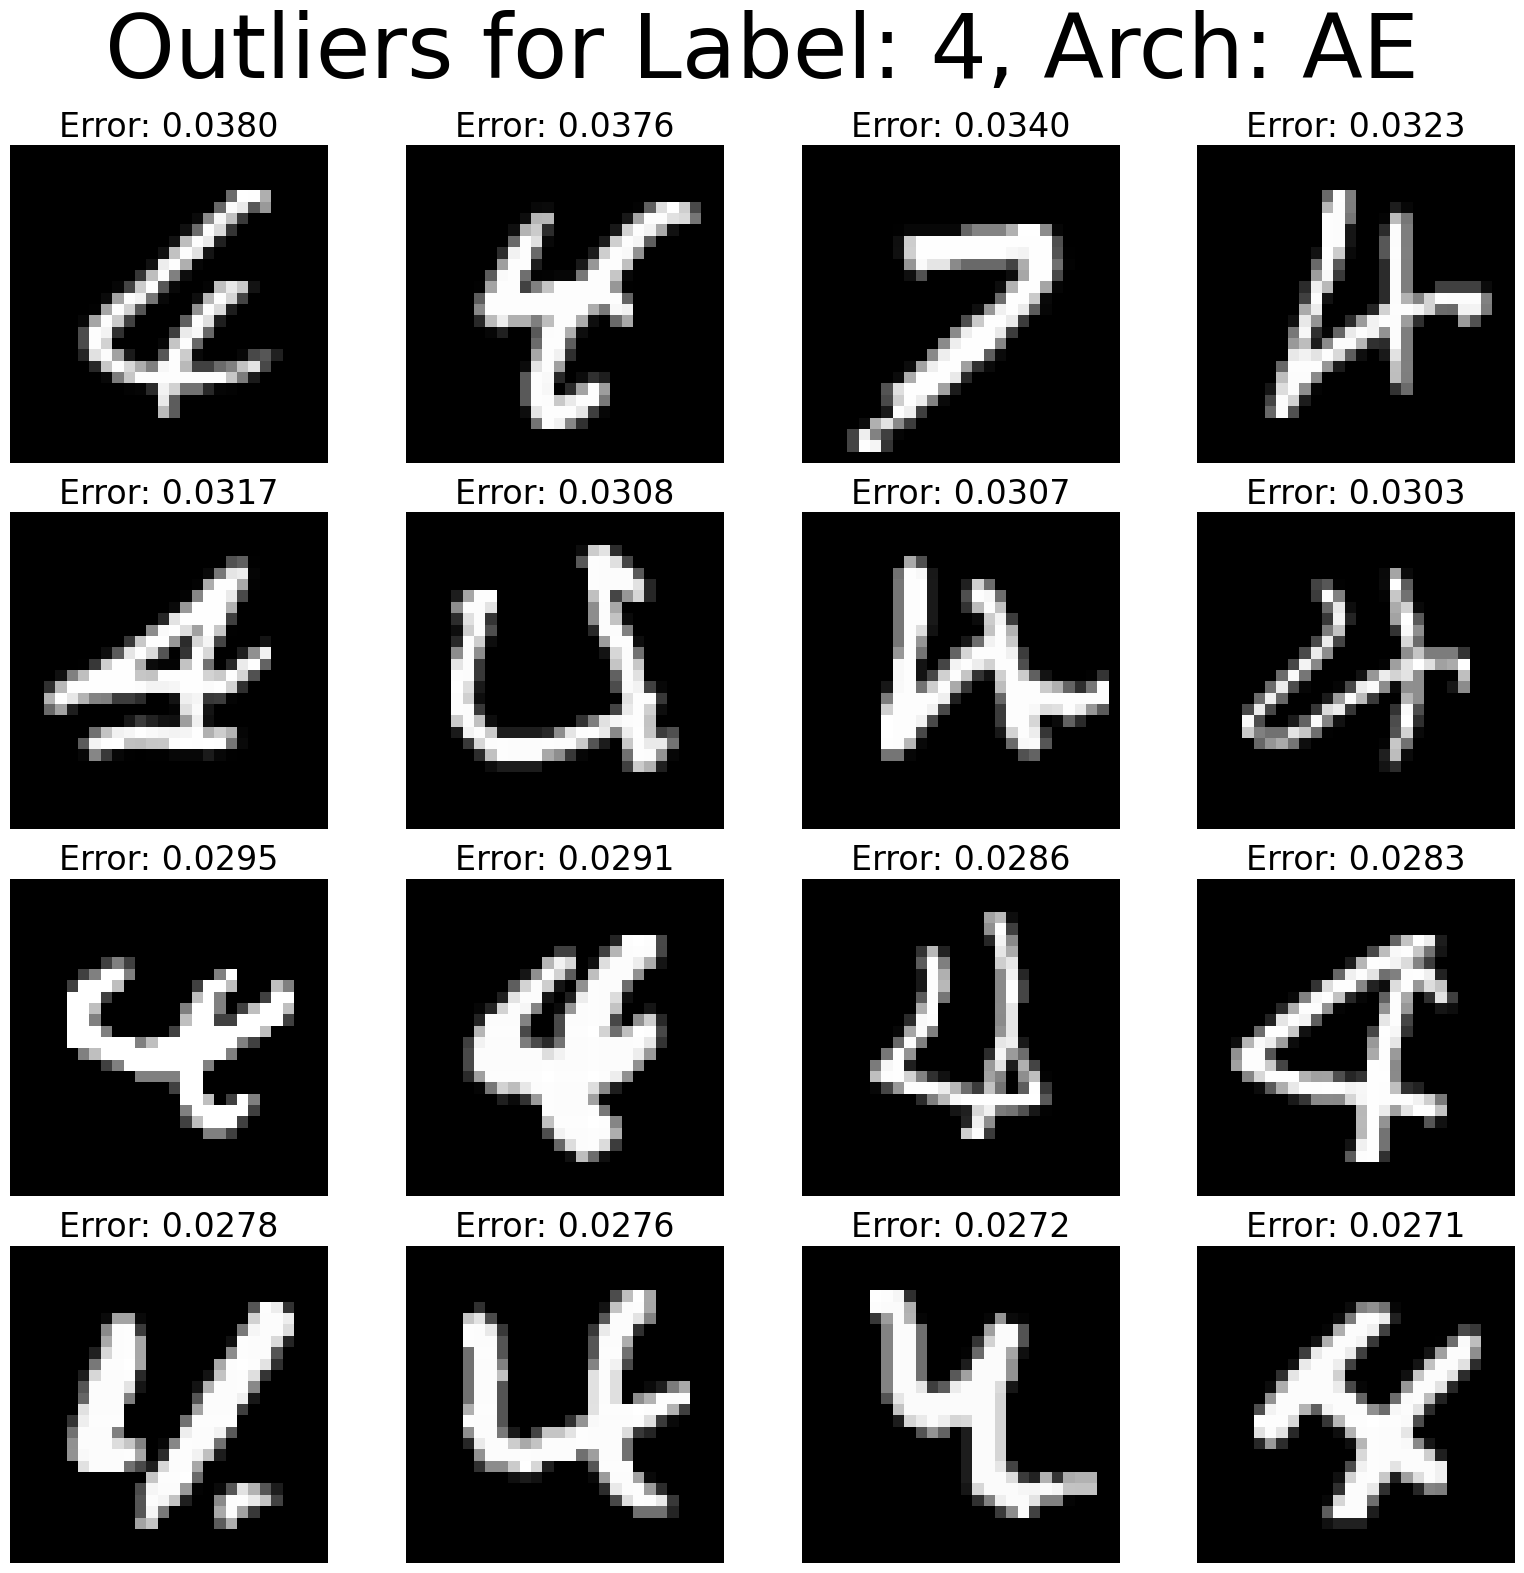

In [259]:
all_losses_ae = identify_outliers(training_data, AE, singleton_loss_fn, cnn=False)
plot_outliers(all_losses_ae, LABEL, num_images=16)

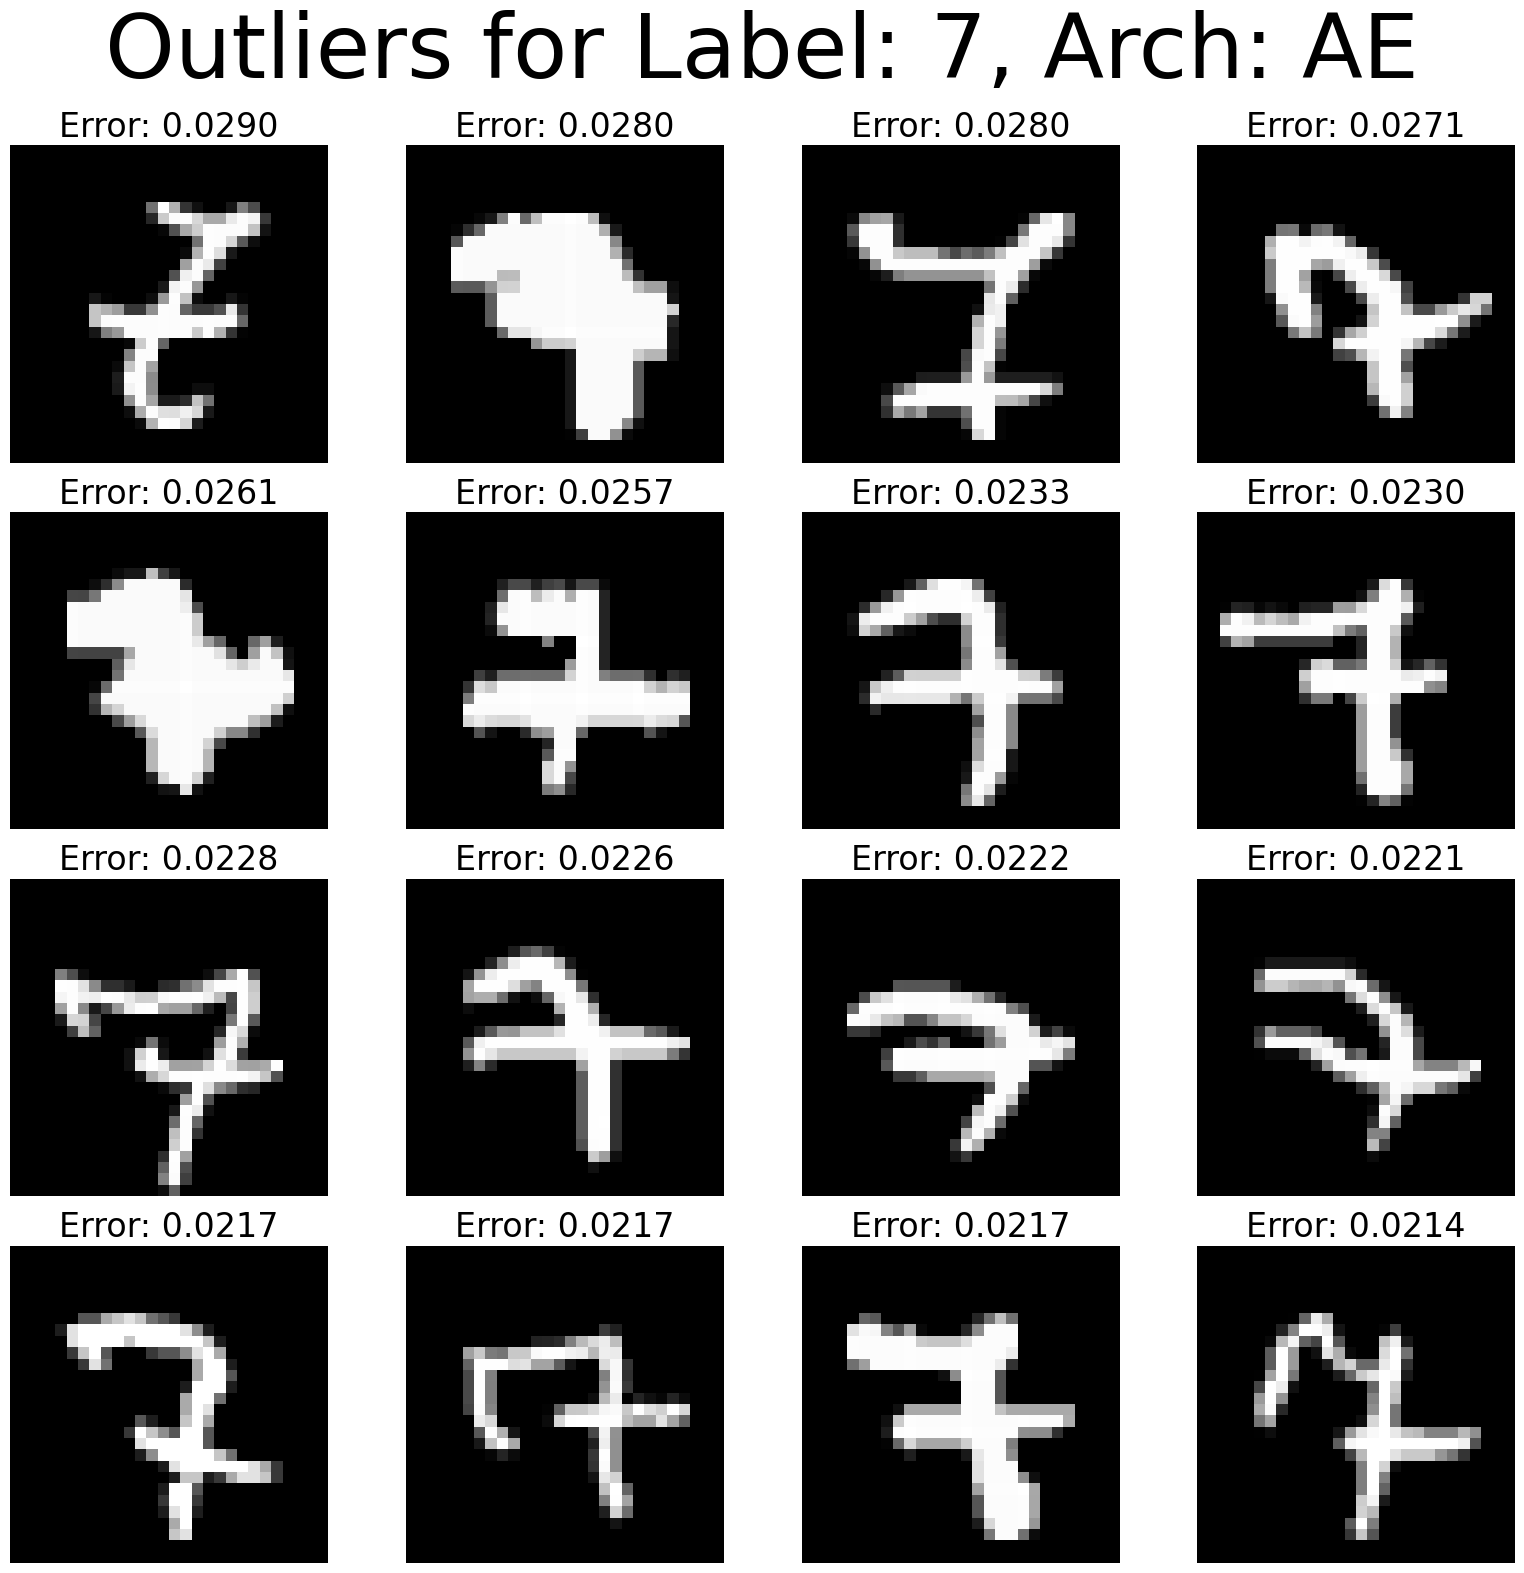

In [243]:
all_losses_ae = identify_outliers(training_data, AE, singleton_loss_fn, cnn=False)
plot_outliers(all_losses_ae, LABEL, num_images=16)

In [255]:
CNN_AE = CNNAutoEncoder().to(device=device)
cnn_learning_rate = 3e-4
cnn_optm = torch.optim.Adam(CNN_AE.parameters(), lr=cnn_learning_rate)
train(training_data, CNN_AE, loss_fn, cnn_optm, cnn=True, num_epochs=200, patience=7)
singleton_loss_fn = torch.nn.MSELoss(reduction='none')

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:01<00:00, 84.64it/s] 


Epoch 1/200, Loss: 0.13412


100%|██████████| 99/99 [00:00<00:00, 152.83it/s]


Epoch 2/200, Loss: 0.06370


100%|██████████| 99/99 [00:00<00:00, 163.61it/s]


Epoch 3/200, Loss: 0.06222


100%|██████████| 99/99 [00:00<00:00, 158.10it/s]


Epoch 4/200, Loss: 0.06076


100%|██████████| 99/99 [00:00<00:00, 158.41it/s]


Epoch 5/200, Loss: 0.05389


100%|██████████| 99/99 [00:00<00:00, 160.30it/s]


Epoch 6/200, Loss: 0.04338


100%|██████████| 99/99 [00:00<00:00, 157.20it/s]


Epoch 7/200, Loss: 0.03296


100%|██████████| 99/99 [00:00<00:00, 162.59it/s]


Epoch 8/200, Loss: 0.02597


100%|██████████| 99/99 [00:00<00:00, 161.65it/s]


Epoch 9/200, Loss: 0.02143


100%|██████████| 99/99 [00:00<00:00, 159.95it/s]


Epoch 10/200, Loss: 0.01849


100%|██████████| 99/99 [00:00<00:00, 166.30it/s]


Epoch 11/200, Loss: 0.01628


100%|██████████| 99/99 [00:00<00:00, 157.21it/s]


Epoch 12/200, Loss: 0.01458


100%|██████████| 99/99 [00:00<00:00, 163.87it/s]


Epoch 13/200, Loss: 0.01317


100%|██████████| 99/99 [00:00<00:00, 161.99it/s]


Epoch 14/200, Loss: 0.01210


100%|██████████| 99/99 [00:00<00:00, 162.49it/s]


Epoch 15/200, Loss: 0.01126


100%|██████████| 99/99 [00:00<00:00, 161.38it/s]


Epoch 16/200, Loss: 0.01057


100%|██████████| 99/99 [00:00<00:00, 164.28it/s]


Epoch 17/200, Loss: 0.00997


100%|██████████| 99/99 [00:00<00:00, 153.08it/s]


Epoch 18/200, Loss: 0.00946


100%|██████████| 99/99 [00:00<00:00, 169.03it/s]


Epoch 19/200, Loss: 0.00901


100%|██████████| 99/99 [00:00<00:00, 166.48it/s]


Epoch 20/200, Loss: 0.00861


100%|██████████| 99/99 [00:00<00:00, 157.92it/s]


Epoch 21/200, Loss: 0.00825


100%|██████████| 99/99 [00:00<00:00, 163.44it/s]


Epoch 22/200, Loss: 0.00793


100%|██████████| 99/99 [00:00<00:00, 159.82it/s]


Epoch 23/200, Loss: 0.00764


100%|██████████| 99/99 [00:00<00:00, 157.78it/s]


Epoch 24/200, Loss: 0.00738


100%|██████████| 99/99 [00:00<00:00, 161.80it/s]


Epoch 25/200, Loss: 0.00715


100%|██████████| 99/99 [00:00<00:00, 160.36it/s]


Epoch 26/200, Loss: 0.00693


100%|██████████| 99/99 [00:00<00:00, 160.31it/s]


Epoch 27/200, Loss: 0.00673


100%|██████████| 99/99 [00:00<00:00, 151.85it/s]


Epoch 28/200, Loss: 0.00655


100%|██████████| 99/99 [00:00<00:00, 162.50it/s]


Epoch 29/200, Loss: 0.00638


100%|██████████| 99/99 [00:00<00:00, 159.55it/s]


Epoch 30/200, Loss: 0.00621


100%|██████████| 99/99 [00:00<00:00, 159.37it/s]


Epoch 31/200, Loss: 0.00606


100%|██████████| 99/99 [00:00<00:00, 134.64it/s]


Epoch 32/200, Loss: 0.00591


100%|██████████| 99/99 [00:00<00:00, 133.62it/s]


Epoch 33/200, Loss: 0.00578


100%|██████████| 99/99 [00:00<00:00, 133.15it/s]


Epoch 34/200, Loss: 0.00565


100%|██████████| 99/99 [00:00<00:00, 142.15it/s]


Epoch 35/200, Loss: 0.00553


100%|██████████| 99/99 [00:00<00:00, 137.11it/s]


Epoch 36/200, Loss: 0.00541


100%|██████████| 99/99 [00:00<00:00, 151.46it/s]


Epoch 37/200, Loss: 0.00530


100%|██████████| 99/99 [00:00<00:00, 138.21it/s]


Epoch 38/200, Loss: 0.00520


100%|██████████| 99/99 [00:00<00:00, 157.32it/s]


Epoch 39/200, Loss: 0.00510


100%|██████████| 99/99 [00:00<00:00, 153.20it/s]


Epoch 40/200, Loss: 0.00501


100%|██████████| 99/99 [00:00<00:00, 160.45it/s]


Epoch 41/200, Loss: 0.00492


100%|██████████| 99/99 [00:00<00:00, 152.21it/s]


Epoch 42/200, Loss: 0.00483


100%|██████████| 99/99 [00:00<00:00, 158.93it/s]


Epoch 43/200, Loss: 0.00475


100%|██████████| 99/99 [00:00<00:00, 154.61it/s]


Epoch 44/200, Loss: 0.00467


100%|██████████| 99/99 [00:00<00:00, 154.89it/s]


Epoch 45/200, Loss: 0.00459


100%|██████████| 99/99 [00:00<00:00, 160.66it/s]


Epoch 46/200, Loss: 0.00452


100%|██████████| 99/99 [00:00<00:00, 149.74it/s]


Epoch 47/200, Loss: 0.00445


100%|██████████| 99/99 [00:00<00:00, 150.90it/s]


Epoch 48/200, Loss: 0.00438


100%|██████████| 99/99 [00:00<00:00, 164.18it/s]


Epoch 49/200, Loss: 0.00432


100%|██████████| 99/99 [00:00<00:00, 149.81it/s]


Epoch 50/200, Loss: 0.00426


100%|██████████| 99/99 [00:00<00:00, 133.43it/s]


Epoch 51/200, Loss: 0.00420


100%|██████████| 99/99 [00:00<00:00, 155.30it/s]


Epoch 52/200, Loss: 0.00414


100%|██████████| 99/99 [00:00<00:00, 146.51it/s]


Epoch 53/200, Loss: 0.00409


100%|██████████| 99/99 [00:00<00:00, 144.40it/s]


Epoch 54/200, Loss: 0.00405


100%|██████████| 99/99 [00:00<00:00, 160.13it/s]


Epoch 55/200, Loss: 0.00400


100%|██████████| 99/99 [00:00<00:00, 154.72it/s]


Epoch 56/200, Loss: 0.00396


100%|██████████| 99/99 [00:00<00:00, 143.95it/s]


Epoch 57/200, Loss: 0.00392


100%|██████████| 99/99 [00:00<00:00, 155.73it/s]


Epoch 58/200, Loss: 0.00388


100%|██████████| 99/99 [00:00<00:00, 147.88it/s]


Epoch 59/200, Loss: 0.00384


100%|██████████| 99/99 [00:00<00:00, 150.51it/s]


Epoch 60/200, Loss: 0.00380


100%|██████████| 99/99 [00:00<00:00, 136.49it/s]


Epoch 61/200, Loss: 0.00374


100%|██████████| 99/99 [00:00<00:00, 158.23it/s]


Epoch 62/200, Loss: 0.00369


100%|██████████| 99/99 [00:00<00:00, 161.08it/s]


Epoch 63/200, Loss: 0.00364


100%|██████████| 99/99 [00:00<00:00, 161.62it/s]


Epoch 64/200, Loss: 0.00359


100%|██████████| 99/99 [00:00<00:00, 158.66it/s]


Epoch 65/200, Loss: 0.00355


100%|██████████| 99/99 [00:00<00:00, 148.06it/s]


Epoch 66/200, Loss: 0.00351


100%|██████████| 99/99 [00:00<00:00, 160.17it/s]


Epoch 67/200, Loss: 0.00347


100%|██████████| 99/99 [00:00<00:00, 154.08it/s]


Epoch 68/200, Loss: 0.00344


100%|██████████| 99/99 [00:00<00:00, 130.00it/s]


Epoch 69/200, Loss: 0.00340


100%|██████████| 99/99 [00:00<00:00, 123.20it/s]


Epoch 70/200, Loss: 0.00337


100%|██████████| 99/99 [00:00<00:00, 154.70it/s]


Epoch 71/200, Loss: 0.00333


100%|██████████| 99/99 [00:00<00:00, 143.86it/s]


Epoch 72/200, Loss: 0.00330


100%|██████████| 99/99 [00:00<00:00, 167.52it/s]


Epoch 73/200, Loss: 0.00327


100%|██████████| 99/99 [00:00<00:00, 168.59it/s]


Epoch 74/200, Loss: 0.00324


100%|██████████| 99/99 [00:00<00:00, 164.07it/s]


Epoch 75/200, Loss: 0.00321


100%|██████████| 99/99 [00:00<00:00, 149.81it/s]


Epoch 76/200, Loss: 0.00318


100%|██████████| 99/99 [00:00<00:00, 148.26it/s]


Epoch 77/200, Loss: 0.00315


100%|██████████| 99/99 [00:00<00:00, 162.31it/s]


Epoch 78/200, Loss: 0.00312


100%|██████████| 99/99 [00:00<00:00, 169.81it/s]


Epoch 79/200, Loss: 0.00310


100%|██████████| 99/99 [00:00<00:00, 166.99it/s]


Epoch 80/200, Loss: 0.00307


100%|██████████| 99/99 [00:00<00:00, 155.28it/s]


Epoch 81/200, Loss: 0.00304


100%|██████████| 99/99 [00:00<00:00, 155.54it/s]


Epoch 82/200, Loss: 0.00302


100%|██████████| 99/99 [00:00<00:00, 148.16it/s]


Epoch 83/200, Loss: 0.00299


100%|██████████| 99/99 [00:00<00:00, 158.38it/s]


Epoch 84/200, Loss: 0.00297


100%|██████████| 99/99 [00:00<00:00, 160.74it/s]


Epoch 85/200, Loss: 0.00294


100%|██████████| 99/99 [00:00<00:00, 161.97it/s]


Epoch 86/200, Loss: 0.00292


100%|██████████| 99/99 [00:00<00:00, 155.10it/s]


Epoch 87/200, Loss: 0.00290


100%|██████████| 99/99 [00:00<00:00, 153.32it/s]


Epoch 88/200, Loss: 0.00288


100%|██████████| 99/99 [00:00<00:00, 153.15it/s]


Epoch 89/200, Loss: 0.00285


100%|██████████| 99/99 [00:00<00:00, 164.33it/s]


Epoch 90/200, Loss: 0.00283


100%|██████████| 99/99 [00:00<00:00, 150.72it/s]


Epoch 91/200, Loss: 0.00281


100%|██████████| 99/99 [00:00<00:00, 145.77it/s]


Epoch 92/200, Loss: 0.00279


100%|██████████| 99/99 [00:00<00:00, 150.78it/s]


Epoch 93/200, Loss: 0.00277


100%|██████████| 99/99 [00:00<00:00, 141.12it/s]


Epoch 94/200, Loss: 0.00275


100%|██████████| 99/99 [00:00<00:00, 152.75it/s]


Epoch 95/200, Loss: 0.00273


100%|██████████| 99/99 [00:00<00:00, 155.08it/s]


Epoch 96/200, Loss: 0.00271


100%|██████████| 99/99 [00:00<00:00, 157.39it/s]


Epoch 97/200, Loss: 0.00269


100%|██████████| 99/99 [00:00<00:00, 160.80it/s]


Epoch 98/200, Loss: 0.00267


100%|██████████| 99/99 [00:00<00:00, 153.48it/s]


Epoch 99/200, Loss: 0.00265


100%|██████████| 99/99 [00:00<00:00, 151.45it/s]


Epoch 100/200, Loss: 0.00264


100%|██████████| 99/99 [00:00<00:00, 154.43it/s]


Epoch 101/200, Loss: 0.00262


100%|██████████| 99/99 [00:00<00:00, 160.18it/s]


Epoch 102/200, Loss: 0.00260


100%|██████████| 99/99 [00:00<00:00, 153.80it/s]


Epoch 103/200, Loss: 0.00258


100%|██████████| 99/99 [00:00<00:00, 157.09it/s]


Epoch 104/200, Loss: 0.00257


100%|██████████| 99/99 [00:00<00:00, 161.94it/s]


Epoch 105/200, Loss: 0.00255


100%|██████████| 99/99 [00:00<00:00, 153.54it/s]


Epoch 106/200, Loss: 0.00254


100%|██████████| 99/99 [00:00<00:00, 150.96it/s]


Epoch 107/200, Loss: 0.00252


100%|██████████| 99/99 [00:00<00:00, 159.78it/s]


Epoch 108/200, Loss: 0.00251


100%|██████████| 99/99 [00:00<00:00, 152.24it/s]


Epoch 109/200, Loss: 0.00249


100%|██████████| 99/99 [00:00<00:00, 155.24it/s]


Epoch 110/200, Loss: 0.00247


100%|██████████| 99/99 [00:00<00:00, 163.25it/s]


Epoch 111/200, Loss: 0.00246


100%|██████████| 99/99 [00:00<00:00, 160.35it/s]


Epoch 112/200, Loss: 0.00245


100%|██████████| 99/99 [00:00<00:00, 153.64it/s]


Epoch 113/200, Loss: 0.00243


100%|██████████| 99/99 [00:00<00:00, 155.88it/s]


Epoch 114/200, Loss: 0.00242


100%|██████████| 99/99 [00:00<00:00, 162.82it/s]


Epoch 115/200, Loss: 0.00241


100%|██████████| 99/99 [00:00<00:00, 152.15it/s]


Epoch 116/200, Loss: 0.00239


100%|██████████| 99/99 [00:00<00:00, 160.60it/s]


Epoch 117/200, Loss: 0.00238


100%|██████████| 99/99 [00:00<00:00, 150.30it/s]


Epoch 118/200, Loss: 0.00237


100%|██████████| 99/99 [00:00<00:00, 161.13it/s]


Epoch 119/200, Loss: 0.00236


100%|██████████| 99/99 [00:00<00:00, 160.70it/s]


Epoch 120/200, Loss: 0.00235


100%|██████████| 99/99 [00:00<00:00, 151.18it/s]


Epoch 121/200, Loss: 0.00234


100%|██████████| 99/99 [00:00<00:00, 163.31it/s]


Epoch 122/200, Loss: 0.00233


100%|██████████| 99/99 [00:00<00:00, 157.35it/s]


Epoch 123/200, Loss: 0.00233


100%|██████████| 99/99 [00:00<00:00, 159.93it/s]


Epoch 124/200, Loss: 0.00231


100%|██████████| 99/99 [00:00<00:00, 162.18it/s]


Epoch 125/200, Loss: 0.00231


100%|██████████| 99/99 [00:00<00:00, 159.39it/s]


Epoch 126/200, Loss: 0.00230


100%|██████████| 99/99 [00:00<00:00, 145.40it/s]


Epoch 127/200, Loss: 0.00230


100%|██████████| 99/99 [00:00<00:00, 159.35it/s]


Epoch 128/200, Loss: 0.00231


100%|██████████| 99/99 [00:00<00:00, 158.77it/s]


Epoch 129/200, Loss: 0.00231


100%|██████████| 99/99 [00:00<00:00, 153.10it/s]


Epoch 130/200, Loss: 0.00230


100%|██████████| 99/99 [00:00<00:00, 158.61it/s]


Epoch 131/200, Loss: 0.00227


100%|██████████| 99/99 [00:00<00:00, 163.04it/s]


Epoch 132/200, Loss: 0.00225


100%|██████████| 99/99 [00:00<00:00, 157.42it/s]


Epoch 133/200, Loss: 0.00223


100%|██████████| 99/99 [00:00<00:00, 155.79it/s]


Epoch 134/200, Loss: 0.00222


100%|██████████| 99/99 [00:00<00:00, 157.95it/s]


Epoch 135/200, Loss: 0.00221


100%|██████████| 99/99 [00:00<00:00, 143.41it/s]


Epoch 136/200, Loss: 0.00220


100%|██████████| 99/99 [00:00<00:00, 159.11it/s]


Epoch 137/200, Loss: 0.00219


100%|██████████| 99/99 [00:00<00:00, 162.14it/s]


Epoch 138/200, Loss: 0.00218


100%|██████████| 99/99 [00:00<00:00, 159.06it/s]


Epoch 139/200, Loss: 0.00217


100%|██████████| 99/99 [00:00<00:00, 156.89it/s]


Epoch 140/200, Loss: 0.00216


100%|██████████| 99/99 [00:00<00:00, 164.00it/s]


Epoch 141/200, Loss: 0.00215


100%|██████████| 99/99 [00:00<00:00, 162.93it/s]


Epoch 142/200, Loss: 0.00215


100%|██████████| 99/99 [00:00<00:00, 157.40it/s]


Epoch 143/200, Loss: 0.00214


100%|██████████| 99/99 [00:00<00:00, 164.45it/s]


Epoch 144/200, Loss: 0.00213


100%|██████████| 99/99 [00:00<00:00, 149.98it/s]


Epoch 145/200, Loss: 0.00212


100%|██████████| 99/99 [00:00<00:00, 158.46it/s]


Epoch 146/200, Loss: 0.00211


100%|██████████| 99/99 [00:00<00:00, 162.68it/s]


Epoch 147/200, Loss: 0.00211


100%|██████████| 99/99 [00:00<00:00, 157.08it/s]


Epoch 148/200, Loss: 0.00210


100%|██████████| 99/99 [00:00<00:00, 157.70it/s]


Epoch 149/200, Loss: 0.00209


100%|██████████| 99/99 [00:00<00:00, 160.68it/s]


Epoch 150/200, Loss: 0.00208


100%|██████████| 99/99 [00:00<00:00, 158.31it/s]


Epoch 151/200, Loss: 0.00208


100%|██████████| 99/99 [00:00<00:00, 152.43it/s]


Epoch 152/200, Loss: 0.00207


100%|██████████| 99/99 [00:00<00:00, 156.03it/s]


Epoch 153/200, Loss: 0.00207


100%|██████████| 99/99 [00:00<00:00, 154.68it/s]


Epoch 154/200, Loss: 0.00206


100%|██████████| 99/99 [00:00<00:00, 152.49it/s]


Epoch 155/200, Loss: 0.00205


100%|██████████| 99/99 [00:00<00:00, 157.67it/s]


Epoch 156/200, Loss: 0.00205


100%|██████████| 99/99 [00:00<00:00, 159.62it/s]


Epoch 157/200, Loss: 0.00204


100%|██████████| 99/99 [00:00<00:00, 159.49it/s]


Epoch 158/200, Loss: 0.00203


100%|██████████| 99/99 [00:00<00:00, 154.85it/s]


Epoch 159/200, Loss: 0.00203


100%|██████████| 99/99 [00:00<00:00, 155.14it/s]


Epoch 160/200, Loss: 0.00203


100%|██████████| 99/99 [00:00<00:00, 162.13it/s]


Epoch 161/200, Loss: 0.00202


100%|██████████| 99/99 [00:00<00:00, 149.71it/s]


Epoch 162/200, Loss: 0.00202


100%|██████████| 99/99 [00:00<00:00, 160.34it/s]


Epoch 163/200, Loss: 0.00202


100%|██████████| 99/99 [00:00<00:00, 160.99it/s]


Epoch 164/200, Loss: 0.00202


100%|██████████| 99/99 [00:00<00:00, 157.95it/s]


Epoch 165/200, Loss: 0.00201


100%|██████████| 99/99 [00:00<00:00, 159.14it/s]


Epoch 166/200, Loss: 0.00201


100%|██████████| 99/99 [00:00<00:00, 153.58it/s]


Epoch 167/200, Loss: 0.00200


100%|██████████| 99/99 [00:00<00:00, 162.97it/s]


Epoch 168/200, Loss: 0.00200


100%|██████████| 99/99 [00:00<00:00, 162.34it/s]


Epoch 169/200, Loss: 0.00200


100%|██████████| 99/99 [00:00<00:00, 144.39it/s]


Epoch 170/200, Loss: 0.00200


100%|██████████| 99/99 [00:00<00:00, 154.80it/s]


Epoch 171/200, Loss: 0.00200


100%|██████████| 99/99 [00:00<00:00, 163.75it/s]


Epoch 172/200, Loss: 0.00199


100%|██████████| 99/99 [00:00<00:00, 156.22it/s]


Epoch 173/200, Loss: 0.00199


100%|██████████| 99/99 [00:00<00:00, 158.54it/s]


Epoch 174/200, Loss: 0.00198


100%|██████████| 99/99 [00:00<00:00, 162.26it/s]


Epoch 175/200, Loss: 0.00197


100%|██████████| 99/99 [00:00<00:00, 159.54it/s]


Epoch 176/200, Loss: 0.00197


100%|██████████| 99/99 [00:00<00:00, 117.90it/s]


Epoch 177/200, Loss: 0.00197


100%|██████████| 99/99 [00:00<00:00, 152.05it/s]


Epoch 178/200, Loss: 0.00196


100%|██████████| 99/99 [00:00<00:00, 137.45it/s]


Epoch 179/200, Loss: 0.00196


100%|██████████| 99/99 [00:00<00:00, 162.93it/s]


Epoch 180/200, Loss: 0.00196


100%|██████████| 99/99 [00:00<00:00, 160.68it/s]


Epoch 181/200, Loss: 0.00196


100%|██████████| 99/99 [00:00<00:00, 154.05it/s]


Epoch 182/200, Loss: 0.00197


100%|██████████| 99/99 [00:00<00:00, 159.65it/s]


Epoch 183/200, Loss: 0.00196


100%|██████████| 99/99 [00:00<00:00, 164.23it/s]


Epoch 184/200, Loss: 0.00194


100%|██████████| 99/99 [00:00<00:00, 157.64it/s]


Epoch 185/200, Loss: 0.00193


100%|██████████| 99/99 [00:00<00:00, 150.44it/s]


Epoch 186/200, Loss: 0.00192


100%|██████████| 99/99 [00:00<00:00, 154.52it/s]


Epoch 187/200, Loss: 0.00191


100%|██████████| 99/99 [00:00<00:00, 152.36it/s]


Epoch 188/200, Loss: 0.00191


100%|██████████| 99/99 [00:00<00:00, 160.48it/s]


Epoch 189/200, Loss: 0.00190


100%|██████████| 99/99 [00:00<00:00, 162.04it/s]


Epoch 190/200, Loss: 0.00190


100%|██████████| 99/99 [00:00<00:00, 158.24it/s]


Epoch 191/200, Loss: 0.00189


100%|██████████| 99/99 [00:00<00:00, 149.83it/s]


Epoch 192/200, Loss: 0.00189


100%|██████████| 99/99 [00:00<00:00, 154.03it/s]


Epoch 193/200, Loss: 0.00189


100%|██████████| 99/99 [00:00<00:00, 152.30it/s]


Epoch 194/200, Loss: 0.00188


100%|██████████| 99/99 [00:00<00:00, 157.08it/s]


Epoch 195/200, Loss: 0.00188


100%|██████████| 99/99 [00:00<00:00, 153.20it/s]


Epoch 196/200, Loss: 0.00188


100%|██████████| 99/99 [00:00<00:00, 152.07it/s]


Epoch 197/200, Loss: 0.00187


100%|██████████| 99/99 [00:00<00:00, 154.48it/s]


Epoch 198/200, Loss: 0.00187


100%|██████████| 99/99 [00:00<00:00, 161.35it/s]


Epoch 199/200, Loss: 0.00187


100%|██████████| 99/99 [00:00<00:00, 155.67it/s]

Epoch 200/200, Loss: 0.00187


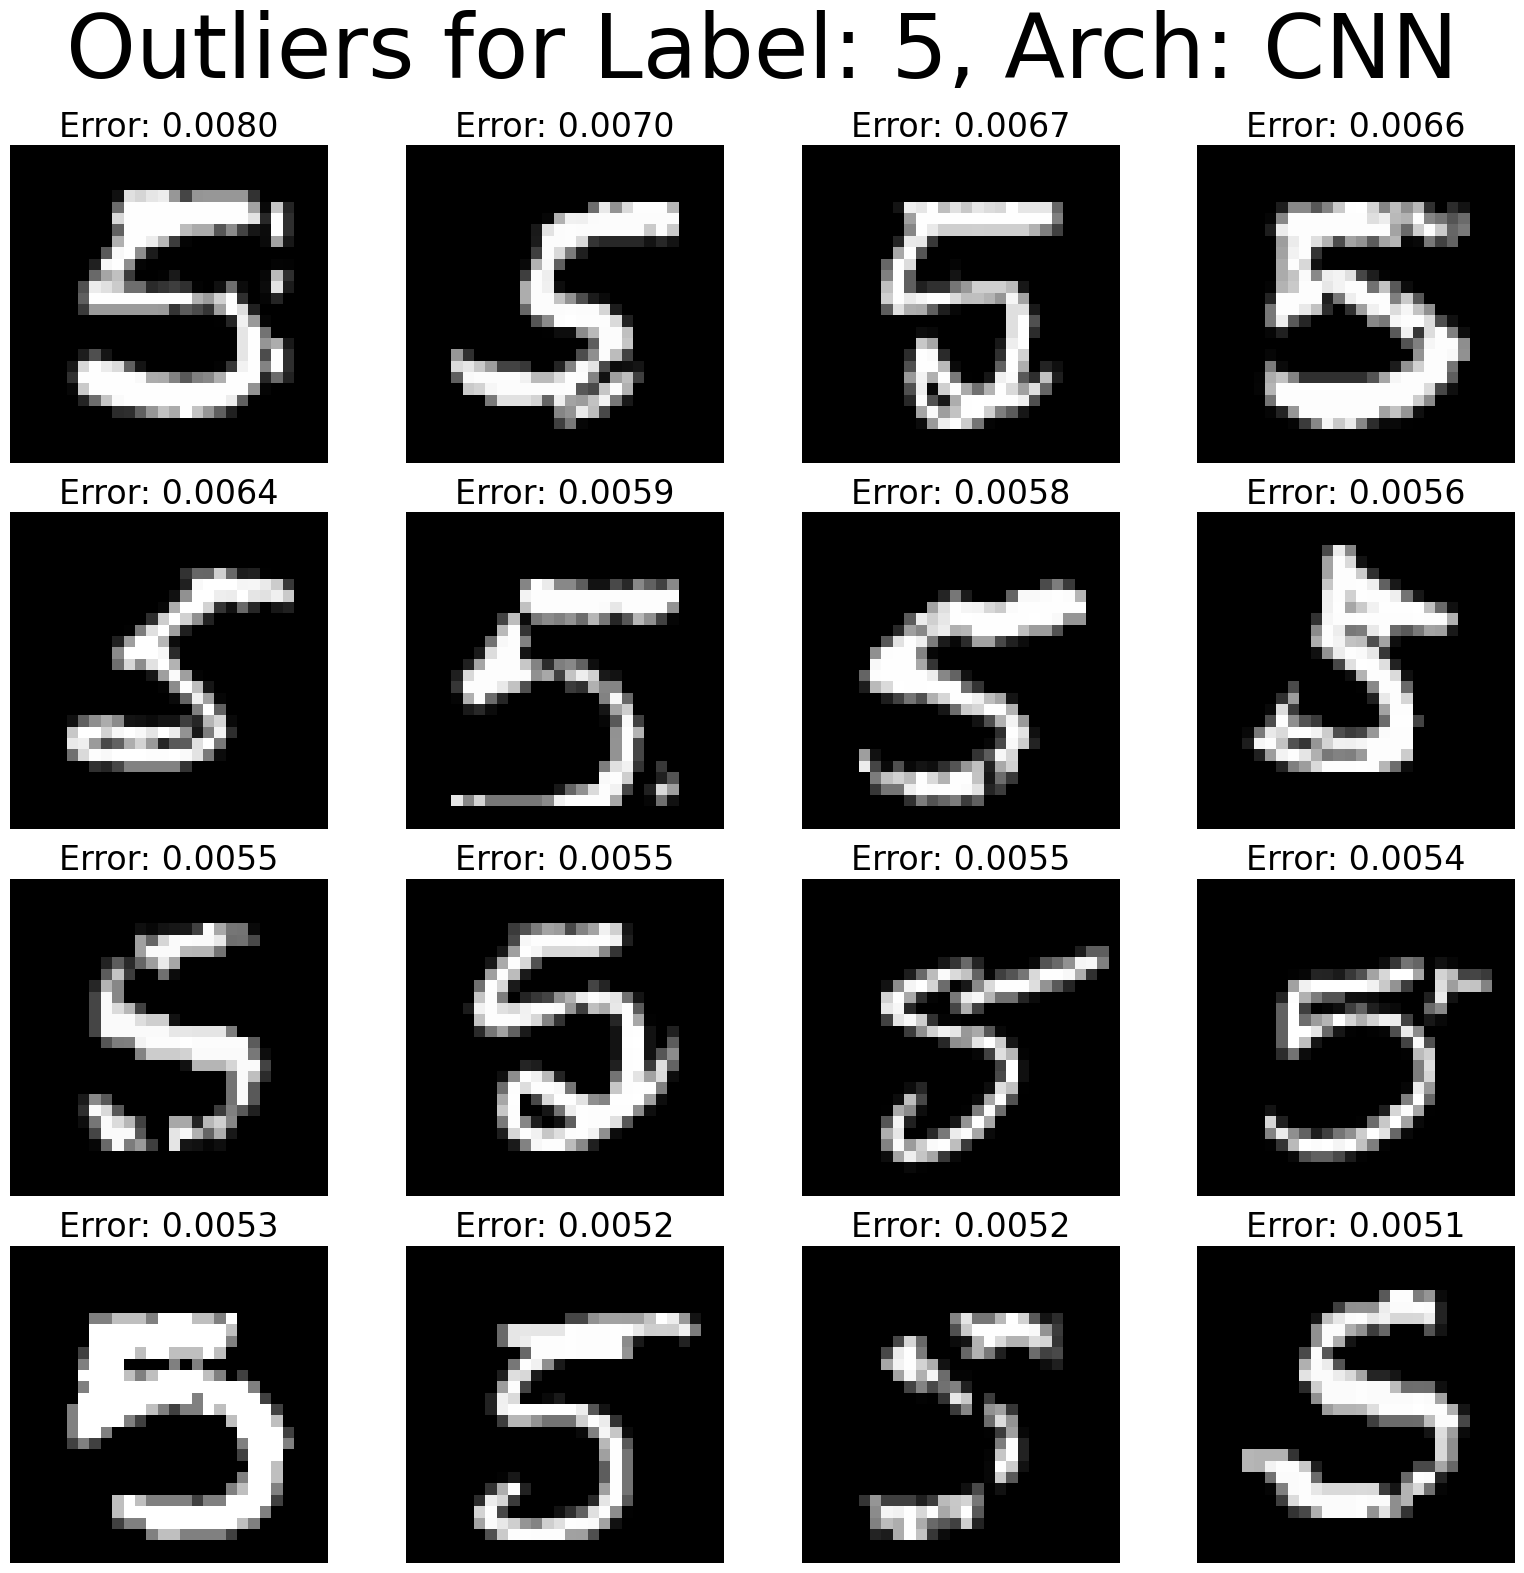

In [256]:
all_losses = identify_outliers(training_data, CNN_AE, singleton_loss_fn, cnn=True)
plot_outliers(all_losses, LABEL, 'CNN', num_images=16)

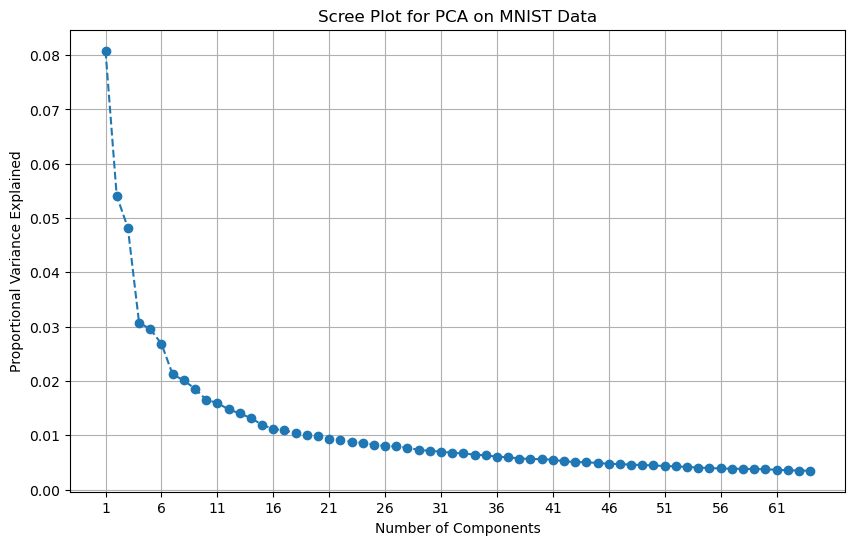

In [226]:
def scree_plot(data, max_components=64):
    data_np = np.array([img.numpy().flatten() for img in data])

    # Standardize the data
    scaler = StandardScaler()
    mnist_data_scaled = scaler.fit_transform(data_np)

    # Compute PCA for different numbers of components
    pca_var = []
    pca = PCA(n_components=max_components)
    pca.fit(mnist_data_scaled)
    pca_var = pca.explained_variance_ratio_
        
    # Plot the scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), pca_var, marker='o', linestyle='--')
    plt.title('Scree Plot for PCA on MNIST Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Proportional Variance Explained')
    plt.grid(True)
    plt.xticks(range(1, max_components + 1, 5))
    plt.show()

scree_plot(number_set[LABEL])

In [252]:

def identify_outliers_pca(data, n_components=28):
    data_np = np.array([img.numpy().flatten() for img in data])

    # Standardize the data
    scaler = StandardScaler() # Just to be sure, since MNIST data is already scaled
    mnist_data_scaled = scaler.fit_transform(data_np)

    # Apply PCA
    pca = PCA(n_components=n_components)
    mnist_data_pca = pca.fit_transform(mnist_data_scaled)

    # Reconstruct the data
    mnist_data_reconstructed = pca.inverse_transform(mnist_data_pca)

    # Compute the reconstruction error
    reconstruction_error = np.mean((mnist_data_scaled - mnist_data_reconstructed) ** 2, axis=1)

    # Identify outliers
    outliers = {}
    for idx, (error, image) in enumerate(zip(reconstruction_error, data_np)):
        outliers[idx] = (error, image)
    
    # Sort outliers by error (descending)
    outliers_sorted = {k: v for k, v in sorted(outliers.items(), key=lambda item: item[1][0], reverse=True)}
    
    return outliers_sorted


def plot_outliers_pca(outliers, num_images=64, label=LABEL, n_components=28):
    grid_size = int(np.sqrt(num_images))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
    fig.suptitle(f'PCA-based Outliers for Label: {label}, N_components= {n_components}', fontsize=32)
    
    for i, (_, (error, image)) in enumerate(list(outliers.items())[:num_images]):
        row = i // grid_size
        col = i % grid_size
        axs[row, col].imshow(image.reshape(28, 28), cmap='gray')
        axs[row, col].set_title(f'Error: {error:.4f}', fontsize=24)
        axs[row, col].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


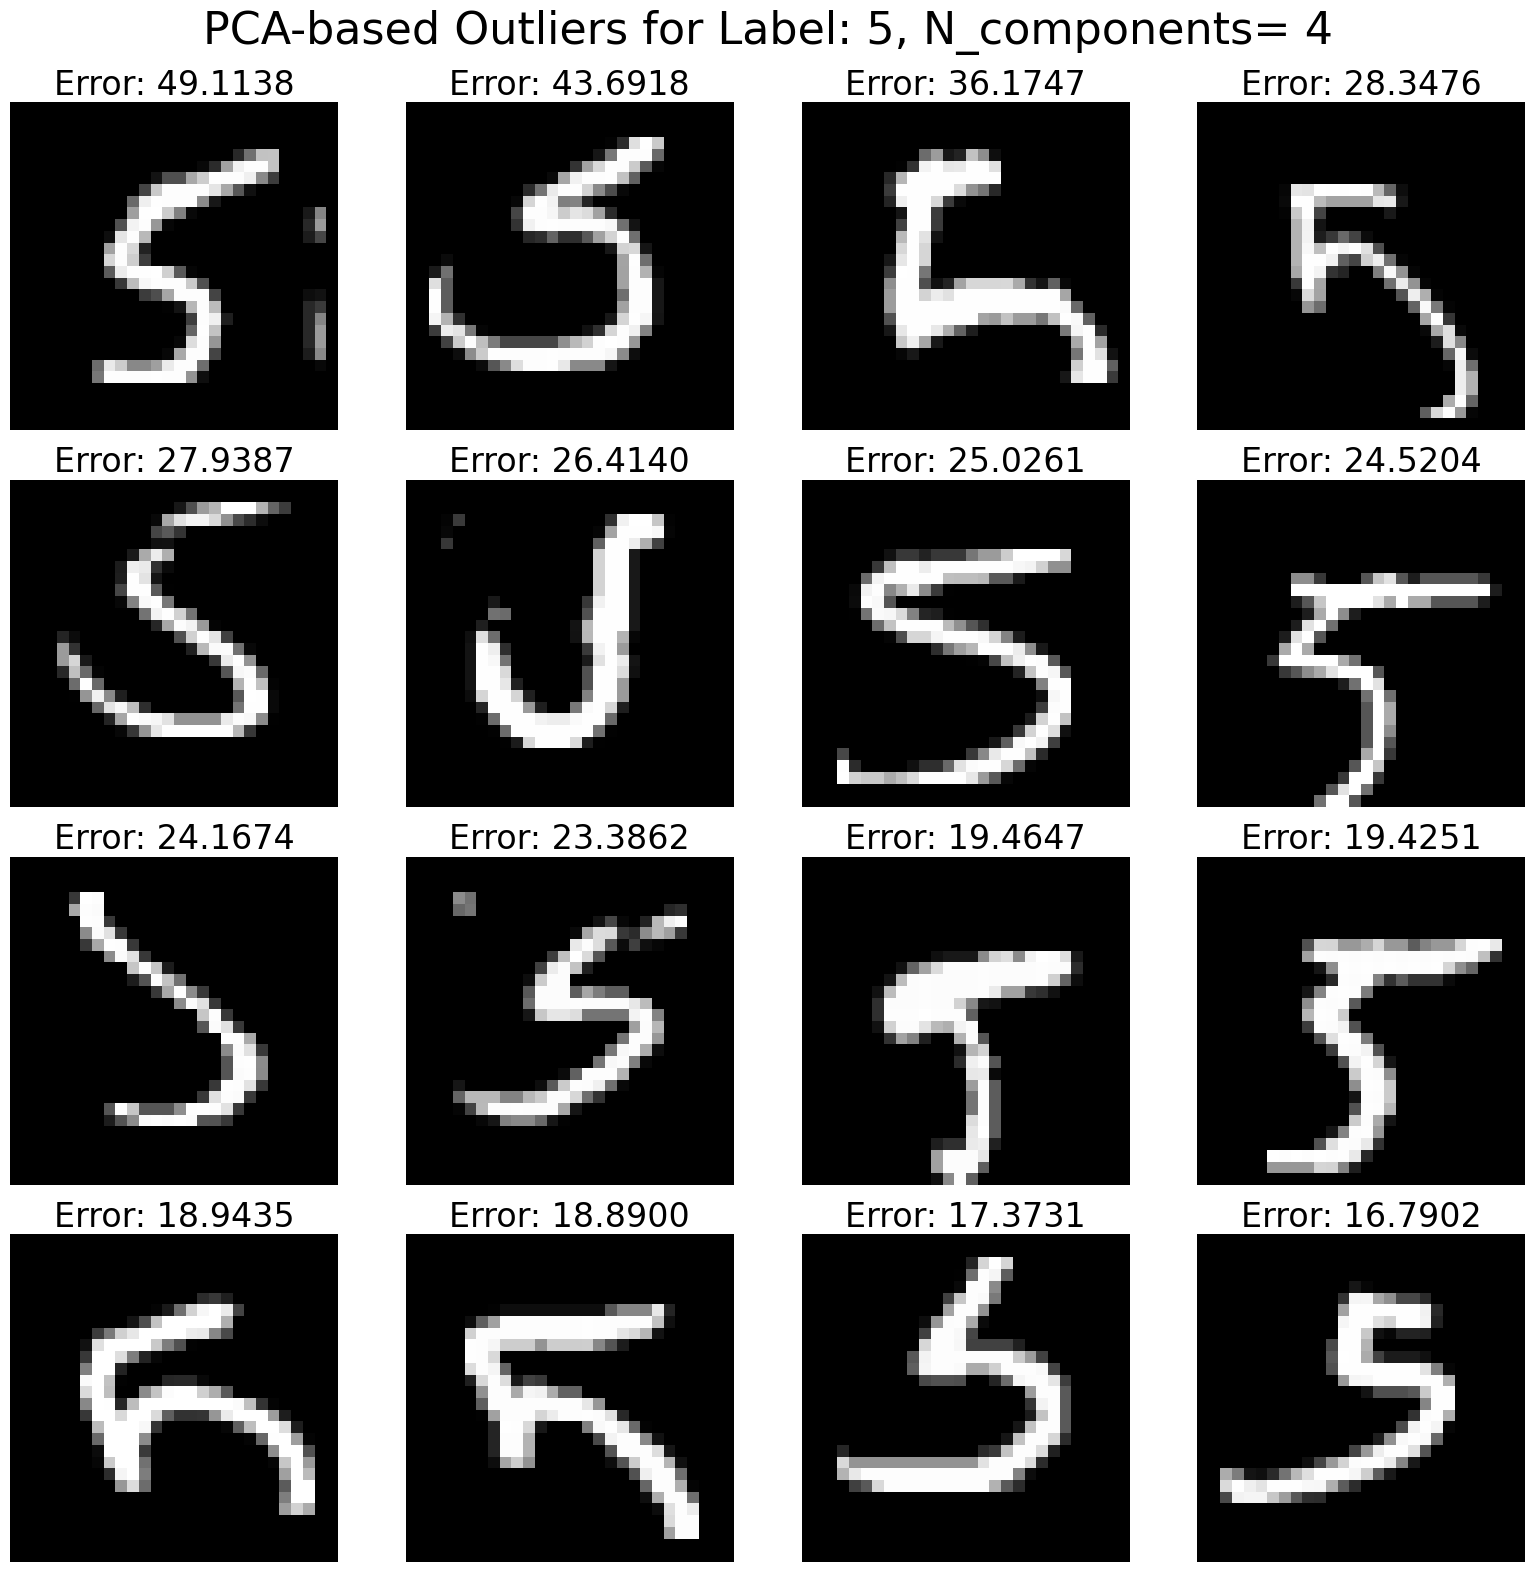

In [253]:
pca_outliers = identify_outliers_pca(number_set[LABEL], n_components=4)
plot_outliers_pca(pca_outliers, num_images=16, n_components=4)

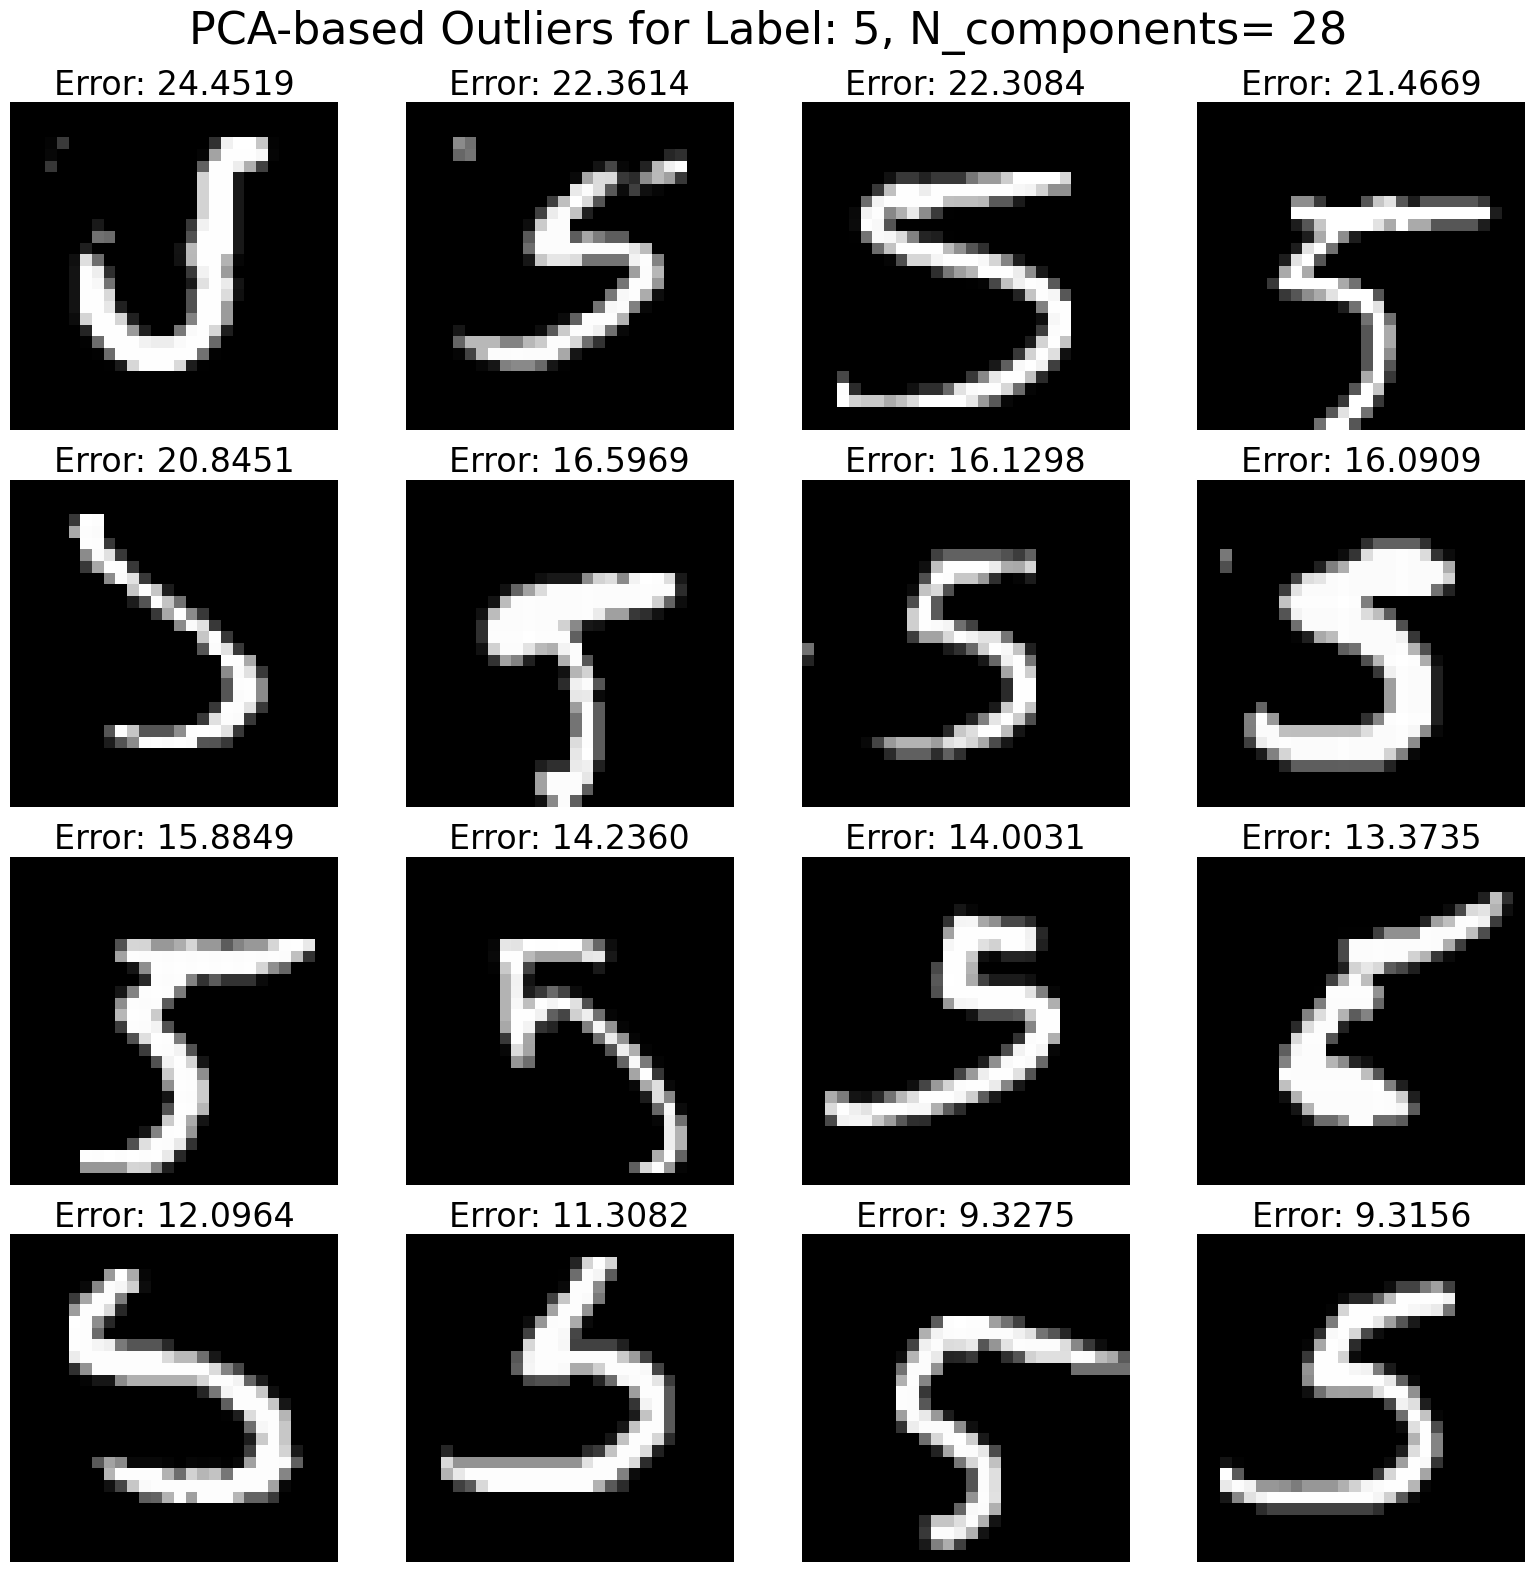

In [254]:
pca_outliers = identify_outliers_pca(number_set[LABEL], n_components=28)
plot_outliers_pca(pca_outliers, num_images=16, n_components=28)

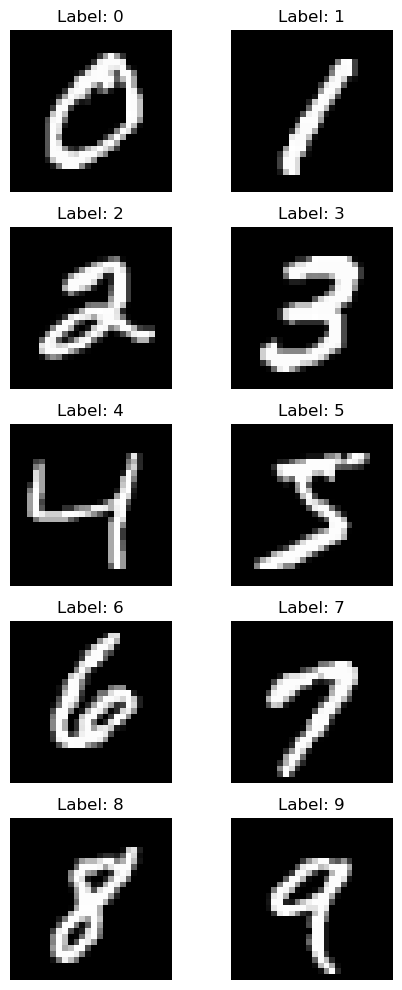

In [196]:

# Create a figure with a 5x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(5, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the digits and plot each one in the corresponding subplot
for i in range(10):
    axes[i].imshow(number_set[i][0][0].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Label: {i}")

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

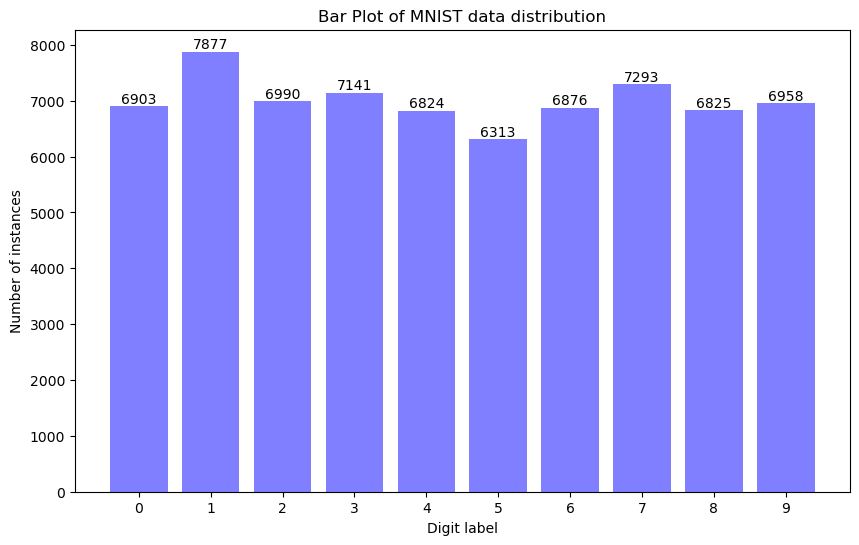

In [195]:
# Extract keys and values from the dictionary
keys = list(count.keys())
values = list(count.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, values, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Digit label')
plt.ylabel('Number of instances')
plt.title('Bar Plot of MNIST data distribution')

# Ensure each key is shown on the x-axis
plt.xticks(keys)

# Add annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Show the plot
plt.show()